In [1]:
import matplotlib.pyplot as plt
from data_reader import *
from random import shuffle
import numpy as np
from esn import EchoStateNetwork
from itertools import product
alpha_c = "\u03b1"
np.set_printoptions(precision=2)

# Introduction

I am analyzing heartbeat data for anomolies. This will be done by training an Echo State Network (ESN), a type of Recurrent Neural Network, on healthy heart beat time series data. I will then measure its performance on 
other healthy controls to get a baseline of testing performance. Finally, I will apply the trained model to sick records, and measure the performance. If the performance dropps significantly, then it can be argued that the patient
is sick.

# Getting the Data

The data comes from a website: 
https://physionet.org/physiobank/database/ptbdb/

The data set is a wave file database for many people and one
or more samples per person. The data is read with a package
called `wfdb`. I've written wrappers to download, load 
the data, and reformat it, so that's obscured from the report.

In [2]:
# Get the data
records = get_records()
data = [get_data(record) for record in records]

In [3]:
# remove data missing labels
data = [record for record in data if record['labels']['vector'] is not None]
healthy_data = [record for record in data if record['labels']['status'] == 'Healthy control']
unhealthy_data = [record for record in data if record['labels']['status'] != 'Healthy control']

The data has 38400 time samples and 15 dimensions. For each record, there is an associated age, sex and sickness.

In [4]:
print(f"Number of records {len(data)}")
print("Shape of data: {}".format(data[0]['data'].shape))
print("Labels:")
ages, sexes, stats = get_totals(data)
print("\tAges:", np.array(ages))
print("\tSexes:", sexes)
print("\tSickness:", stats)

Number of records 513
Shape of data: (38400, 15)
Labels:
	Ages: ['17' '22' '24' '25' '26' '28' '29' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '50'
 '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64'
 '65' '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78'
 '79' '80' '81' '82' '84' '85' '86' '87']
	Sexes: ['female' 'male']
	Sickness: ['Bundle branch block' 'Cardiomyopathy' 'Dysrhythmia' 'Healthy control'
 'Heart failure (NYHA 2)' 'Heart failure (NYHA 3)'
 'Heart failure (NYHA 4)' 'Hypertrophy' 'Myocardial infarction'
 'Myocarditis' 'Palpitation' 'Stable angina' 'Unstable angina'
 'Valvular heart disease']


In [5]:
healthy_data[0]['data'].shape, healthy_data[0]

((115200, 15),
 {'fs': 1000,
  'sig_len': 115200,
  'n_sig': 15,
  'base_date': None,
  'base_time': None,
  'units': ['mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV'],
  'sig_name': ['i',
   'ii',
   'iii',
   'avr',
   'avl',
   'avf',
   'v1',
   'v2',
   'v3',
   'v4',
   'v5',
   'v6',
   'vx',
   'vy',
   'vz'],
  'comments': ['age: 58',
   'sex: male',
   'ECG date: 13/07/1992',
   'Diagnose:',
   'Reason for admission: Healthy control',
   'Acute infarction (localization): no',
   'Former infarction (localization): no',
   'Additional diagnoses: no',
   'Smoker: unknown',
   'Number of coronary vessels involved: unknown',
   'Infarction date (acute): n/a',
   'Previous infarction (1) date: n/a',
   'Previous infarction (2) date: n/a',
   'Hemodynamics:',
   'Catheterization date: n/a',
   'Ventriculography: n/a',
   'Chest X-ray: n/a',
   'Peripheral blood Pressure (syst/diast): n/a',
   'Pulmona

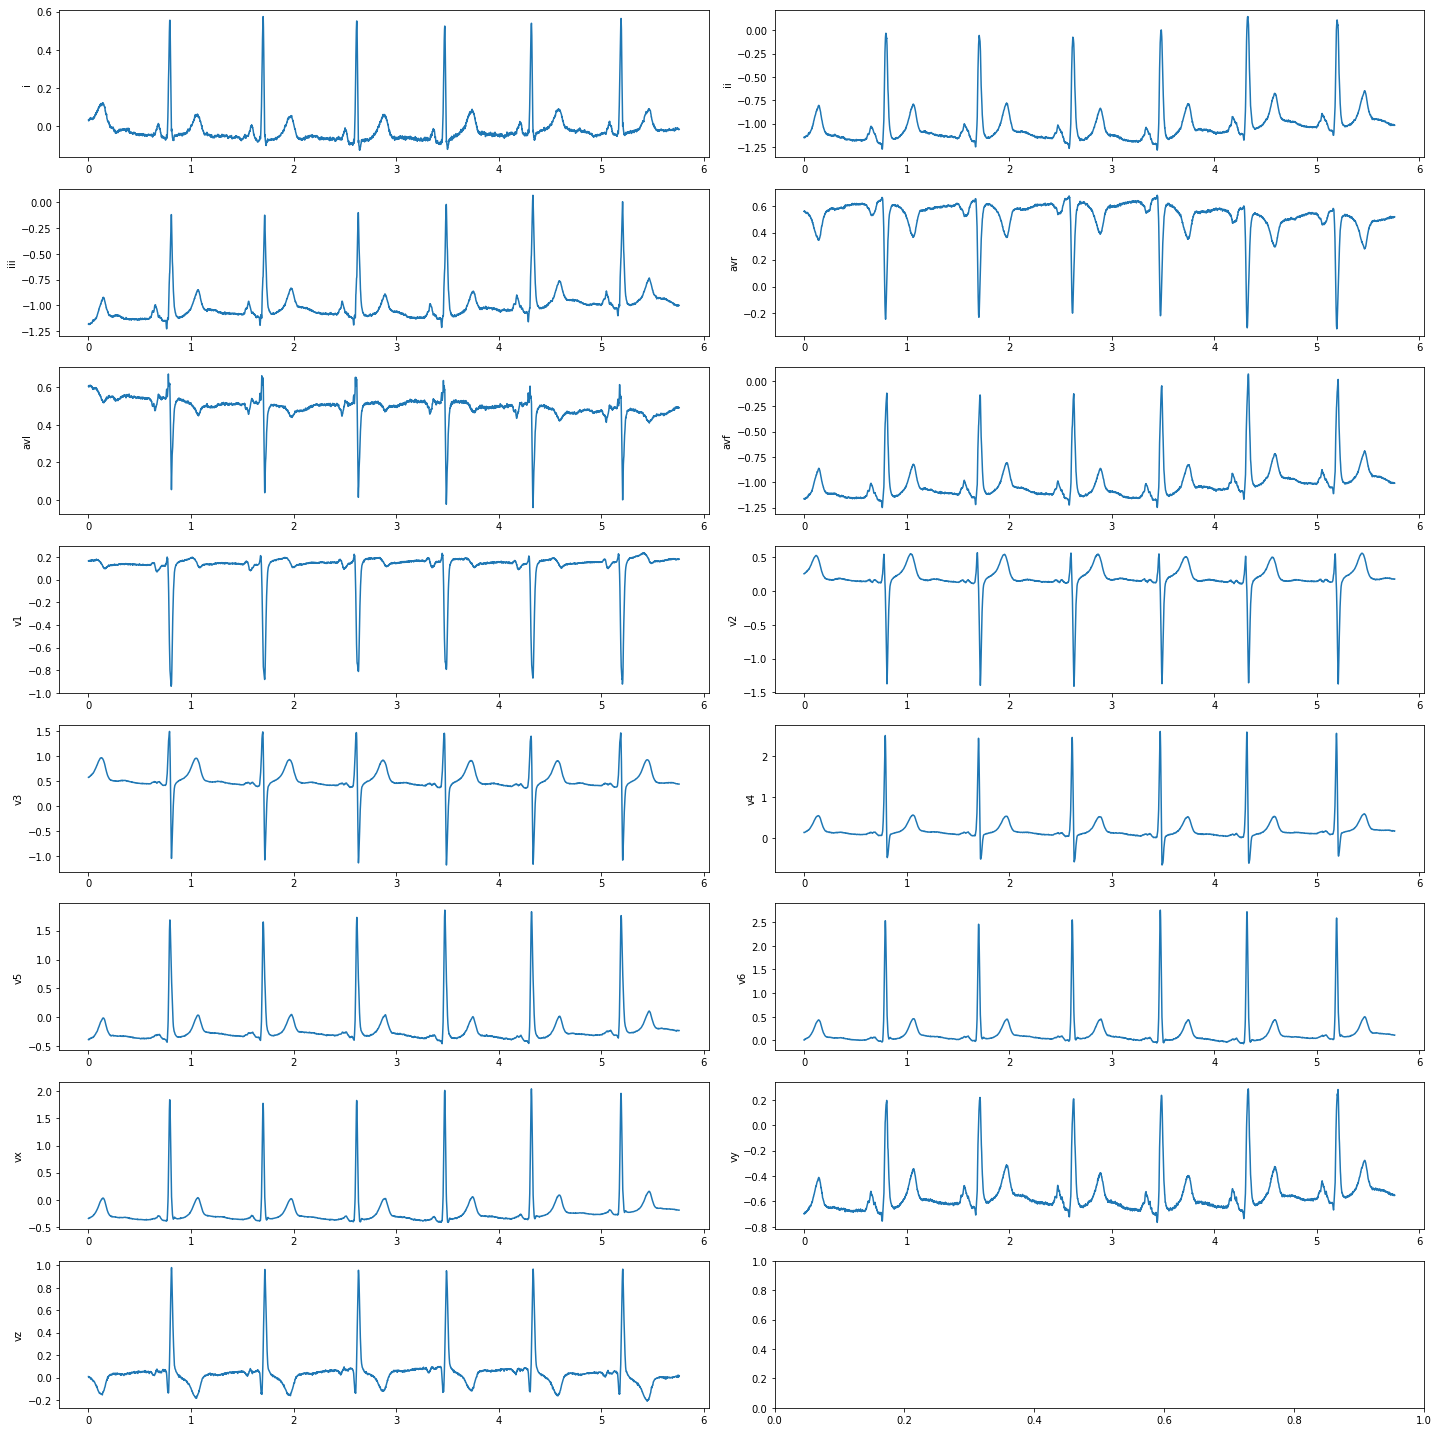

In [6]:
def plot_record(record, split=.05):
    ts_data = record['data']
    dims = record['sig_name']
    portion = int(split*ts_data.shape[0])
    freq = record['fs']
    t = np.arange(portion) / freq
    fig, axs = plt.subplots(8, 2, figsize=(20, 20))
    for i in range(15):
        y, x = i//2, i%2
        axs[y, x].plot(t, ts_data[:portion, i])
        axs[y, x].set_ylabel(dims[i])
    plt.tight_layout()
plot_record(healthy_data[0])

# Training the Model

The input vector will be the age and sex. Age is normalized (by dividing by 100), and 
sex is converted to an indicator variable.

In [10]:
print(f"Number of controls: {len(healthy_data)}")
print(f"Number of sick: {len(unhealthy_data)}")

Number of controls: 73
Number of sick: 440


In [13]:
# Parameters
K = 2
L = 15
T0 = 5000 # more than enough
Ns = [10, 15, 20, 25, 50, 75, 100, 125, 150]
alphas = [.8, .85, .9, .925, 0.95, .98]

## Healthy Performance on Same Record

First, we look at the performance of the model on a single record of a healthy patient.

In [14]:
performances = []
for i, record in enumerate(healthy_data[:1]):
    ds, us = reformat_data(record)
    split_ind = int(ds.shape[0]*.9)
    trials = 5
    performances.append({})
    performance = performances[-1]
    for N, alpha in product(Ns, alphas):
        performance[(N, alpha)] = []
        for _ in range(trials):
            esn = EchoStateNetwork(K, N, L, T0, alpha)
            esn.fit(ds[:split_ind], us[:split_ind])
            ys = esn.predict(ds[:split_ind], us)
            rmse_v = rmse(ys[split_ind:], ds[split_ind:])
            performance[(N, alpha)].append(rmse_v)
            print(f"N={N}, {alpha_c}={alpha}, rmse={np.mean(rmse_v)} {(np.min(rmse_v), np.max(rmse_v))}")

N=10, α=0.8, rmse=90.14927353254468 (6.0411410884596926, 295.68793040727815)
N=10, α=0.8, rmse=18.579252278473497 (0.39643251889379416, 64.63039891294076)
N=10, α=0.8, rmse=13.935458326520541 (0.6103866293217247, 39.19173293497155)
N=10, α=0.8, rmse=0.41271824486098246 (0.03095243757529217, 1.5946538153702903)
N=10, α=0.8, rmse=0.08613730565772196 (0.009708539208505193, 0.16005725991681813)
N=10, α=0.85, rmse=19.757532320566668 (0.10305612206544491, 48.429944925849995)
N=10, α=0.85, rmse=0.29264889844447445 (0.009054494643833974, 0.9847899254073206)
N=10, α=0.85, rmse=8.691406507769967 (0.016428953835859808, 25.205074337487954)
N=10, α=0.85, rmse=11.52947152078651 (0.20417702121342438, 31.357178963147305)
N=10, α=0.85, rmse=0.2438308220033362 (0.02926973980218827, 0.7333231167994594)
N=10, α=0.9, rmse=0.07989076738981644 (0.010178840014953705, 0.13837011598097954)
N=10, α=0.9, rmse=7.702935215898843 (0.01308430890628394, 26.49397640589304)
N=10, α=0.9, rmse=0.10950318136145798 (0.01265

KeyboardInterrupt: 

In [ ]:
rmses = np.zeros((0, 15))
performance = performances[0]
for key in performance:
    rmses = np.vstack((rmses, performance[key]))
dim_rmse = np.mean(rmses, axis=0)
print("RMSE by dim:", dim_rmse)
simple_dims = np.argsort(dim_rmse)
print("Top dims: ", simple_dims[:5])

The most predictable dimensions are shown in the list above. We need an accurate model, so we can, if needed, ignore the other dimensions. However, the other dimensions may provide signals, so that will have to be investigated before doing so.

In [ ]:
n_rmse = {}
a_rmse = {}
performance = performances[0]
for N, alpha in performance:
    if N not in n_rmse:
        n_rmse[N] = performance[(N, alpha)]
    else:
        n_rmse[N] = np.vstack((n_rmse[N], performance[(N, alpha)]))
    if alpha not in a_rmse:
        a_rmse[alpha] = performance[(N, alpha)]
    else:
        a_rmse[alpha] = np.vstack((a_rmse[alpha], performance[(N, alpha)]))
rmse_vs_N = [np.mean(n_rmse[N]) for N in sorted(n_rmse.keys())]
rmse_vs_a = [np.mean(a_rmse[alpha]) for alpha in sorted(a_rmse.keys())]

In [ ]:
plt.subplots(figsize=(15, 5))
plt.subplot(121)
plt.title("RMSE vs N")
plt.plot(sorted(n_rmse.keys()), rmse_vs_N, "o-")
plt.subplot(122)
plt.title("RMSE vs $\\alpha$")
plt.plot(sorted(a_rmse.keys()), rmse_vs_a, "o-");

These results show that the ESN should have a somewhat large network of 100 internal units, and an alpha value of around 0.925

## Healthy Performance Cross Records

## Unhealthy Performance